# Rusty Bargain Models Evaluations

# Introduction

The company Rusty Bargain wants a model developed to predict the market value of a used car given certain specifications. The main goal of the project is to develop models using gradient boosting libraries (LightGBM, XGBoost, and/or CatBoost) in addition to Scikit-Learn's linear regression and random forest regression, which I am more accustomed with. I will compare the quality, training run time, and prediction run time of the models, after preprocessing the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from sklearnex import patch_sklearn # Enhanced performance package for Intel processors
# patch_sklearn()

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from lightgbm import LGBMRegressor
import catboost as cb
from xgboost import XGBRegressor

# Load, process, & explore data

In [2]:
try:
    df = pd.read_csv('car_data.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

Let's check out datatypes and nan's using .info().

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Looks like there are quite a few nans. 

I will standardize column names before moving on to missing values.

In [4]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

## Missing values

In [5]:
df.describe(include='all')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,15470,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,18592
top,05/03/2016 14:25,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,03/04/2016 00:00,NaN,NaN,07/04/2016 07:16
freq,66,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,654
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Dropping all observations with nans indiscriminately leads to over 100,000 observations being lost. Instead, let's move through each feature with missing values and ideally replace the nans with values that make sense. 

In [6]:
df.vehicle_type.unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [7]:
df.fuel_type.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Looks like "other" is already a value in some of these categories. Let's replace nans in categorical features with "unknown".

In [8]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired', 'postal_code']
for feat in cat_features:
    df[feat] = df[feat].fillna('unknown')
    df[feat] = df[feat].astype('category')

I want to drop unnecessary features before looking closely into missing values in the numeric columns. None of the dates are important, and would likely cause problems with the algorithm. And, because postal code is actually a categorical column rather than a numerical one, this will also cause problems during encoding and training. These features are not intrinsic to the automobiles. Registration month also seems trivial compared to the significance of the registration year.

In [9]:
df = df.drop(['date_crawled', 'registration_month', 'date_created', 'postal_code', 'last_seen'], axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               354369 non-null  int64   
 1   vehicle_type        354369 non-null  category
 2   registration_year   354369 non-null  int64   
 3   gearbox             354369 non-null  category
 4   power               354369 non-null  int64   
 5   model               354369 non-null  category
 6   mileage             354369 non-null  int64   
 7   fuel_type           354369 non-null  category
 8   brand               354369 non-null  category
 9   not_repaired        354369 non-null  category
 10  number_of_pictures  354369 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 15.9 MB


The df has been trimmed down and nans filled in. Now I want to look more closely at the numeric features to make sure the values make sense. I will focus more on removing rows with flawed numerical data than I did on removing rows with missing categorical data. The effect of "unknowns" on the machine learning outcomes should be smaller than the effect of very incorrect numbers. I hope to scale the numeric data, and extreme/arbitrary outliers would affect this.

In [11]:
df.describe()

,price,registration_year,power,mileage,number_of_pictures
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.0
mean,4416.656776,2004.234448,110.094337,128211.172535,0.0
std,4514.158514,90.227958,189.850405,37905.341530,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.0
25%,1050.000000,1999.000000,69.000000,125000.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,0.0
75%,6400.000000,2008.000000,143.000000,150000.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,0.0


Price, which will be the target, has some 0 values, which is technically possible but seems unlikely.

Registration_year has values at 1000 and 9999, both of which are unreasonable. I want to explore for more values like this.

Power has values at 0 and 20,000, both of which are unreasonable.

Mileage has over half of the values as 150,000, which seems to represent the ceiling for what the mileage is allowed to be. I will not tweak this column.

The feature number_of_pictures looks to be useless, as every value is 0. I will just drop this column.

In [12]:
df = df.drop('number_of_pictures', axis=1)

I want to check out some of the rows where the price is 0.

In [13]:
print(df[df.price == 0].count()[0])
df[df.price == 0].sample(10, random_state=0)

10772


,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
33139,0,unknown,1990,unknown,0,corsa,150000,unknown,opel,unknown
37386,0,small,1997,manual,60,ka,150000,petrol,ford,unknown
183676,0,small,2002,auto,0,fortwo,150000,gasoline,smart,no
191182,0,small,2001,manual,55,seicento,90000,petrol,fiat,yes
156065,0,unknown,2016,manual,60,punto,150000,unknown,fiat,no
47795,0,small,1996,manual,0,golf,150000,petrol,volkswagen,unknown
312852,0,sedan,1999,auto,193,a4,150000,petrol,audi,yes
175419,0,unknown,1990,unknown,0,unknown,150000,unknown,sonstige_autos,unknown
304637,0,sedan,1998,auto,0,5er,150000,petrol,bmw,unknown
214842,0,sedan,1997,manual,75,golf,150000,petrol,volkswagen,no


It seems like a lot of the ~11,000 observations with a price of 0 have other unknowns as well. It seems like most of this sample has high mileage (>150,000) and/or were registered in the 1900's. It could be reasonable that these automobiles were sold for free. I will keep these in.

In [14]:
print(df.shape)
df = df.drop(df.loc[df.price==0].index)
df.shape

(354369, 10)


(343597, 10)

Next I want to drop rows containing unreasonable values in registration_year. First I want to examine a histogram, zoomed in on the range of years that could be plausable for used cars.

Text(0.5, 1.0, 'Distribution of registration years')

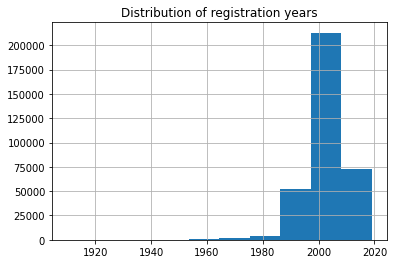

In [15]:
df.registration_year.loc[(df.registration_year > 1900) & (df.registration_year < 2023)].hist()
plt.title("Distribution of registration years")

Registration year values end at 2019, and peter off around 1950/1960. I will remove any values before 1950 and after 2019.

In [16]:
print(df.shape)
drops = df.loc[(df.registration_year < 1950) | (df.registration_year > 2019)].index
df = df.drop(drops)
print(df.shape)

(343597, 10)
(343332, 10)


I will follow the same process for horsepower. Quick research shows that top-of-the-line cars in 2022 had ~2,000hp. And 0hp seems very unlikely for an automobile.

Text(0.5, 1.0, 'Distribution of horsepower')

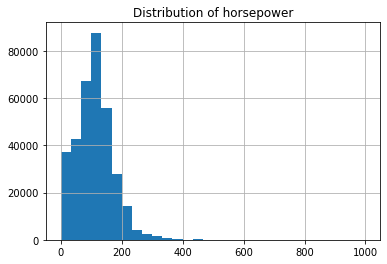

In [17]:
df.power[df.power < 1000].hist(bins=30)
plt.title("Distribution of horsepower")

In [18]:
df.loc[df.power >500]

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,unknown
6296,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,unknown
...,...,...,...,...,...,...,...,...,...,...
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353493,12500,unknown,2017,manual,2000,other,60000,gasoline,chrysler,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,unknown


Checking out rows where power is 0.

In [19]:
df.loc[df.power==0]

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
32,245,sedan,1994,unknown,0,golf,150000,petrol,volkswagen,no
37,1500,unknown,2016,unknown,0,kangoo,150000,gasoline,renault,no
54,4700,wagon,2005,manual,0,signum,150000,unknown,opel,no
55,550,wagon,1999,manual,0,astra,150000,gasoline,opel,yes
...,...,...,...,...,...,...,...,...,...,...
354336,3299,unknown,2005,auto,0,outlander,150000,petrol,mitsubishi,unknown
354338,180,unknown,1995,unknown,0,unknown,125000,petrol,opel,unknown
354346,2600,unknown,2005,auto,0,c_klasse,150000,unknown,mercedes_benz,unknown
354363,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no


Google searching some of these results reveals that both these high and low power values are not correct. I would rather not use data that is flagrantly wrong  to train my models, so I will at least remove rows where horsepower is over 500. There are likely rows where power is under 500 and power is still incorrect, but I would rather be conservative. I will also remove rows where power is 0, because I observe a lot of unknowns when looking at a sample of these rows. Removing these rows should help to clear up the data.

In [20]:
print(df.shape)
df = df.drop(df[(df.power>500) | (df.power==0)].index)
df.shape

(343332, 10)


(306734, 10)

# Create models

I intend to create a linear regression model, a random forest regression model, and three gradient boosted models - built with LightGBM, XGBoost, and CatBoost.

My target will be the price column. My features will include the other columns, as I have already trimmed down the dataframe into just the columns I desire.

Originally I built models with standardized numeric data, but its impact was trivial. This also prevented me from cross-validating and using GridSearch, so I removed the standardization.

In [21]:
def rmse_calc(actual, prediction):
    """
    This function is a shortcut for returning the root mean square error of a prediction or set of predictions.
    """
    rmse = np.sqrt(mean_squared_error(actual, prediction))
    return(rmse)

In [22]:
def pop_row(df):
    """
    This function saves a random observation from a dataframe into its own variable, and then removes that row from the original dataframe. 
    I will use this function to see how long it takes for the models to make one prediction. 
    
    The function takes the dataframe as an input, and saves and drops a row, saves the features and the price into their own feature and 
    target series, and returns these two series as a tuple.
    """
    my_pred = df.sample(1, random_state=0)
    df = df.drop(my_pred.index)
    my_pred_feat = my_pred.drop('price', axis=1)
    my_pred_target = my_pred.price
    return my_pred_feat, my_pred_target

## Linear Regression

Let's first train a linear regression model. 

In [23]:
df_ohe = pd.get_dummies(df, drop_first=True)

target_ohe = df_ohe.price
features_ohe = df_ohe.drop('price', axis=1)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.1, random_state=0)

In [24]:
%%time
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)

CPU times: user 18.3 s, sys: 4.07 s, total: 22.4 s
Wall time: 22.4 s


LinearRegression()

The model took 22 CPU seconds to train. Let's make our predictions and see how long it takes. We can divide the time by the length of the test set to get the average time taken to make one prediction.

In [25]:
%%time
pred = model.predict(features_test_ohe)

CPU times: user 29 ms, sys: 87.4 ms, total: 116 ms
Wall time: 120 ms


In [26]:
num_predictions = features_test_ohe.shape[0]
num_predictions

30674

In [27]:
# 0.107 s / 30674 predictions
.107 / num_predictions

3.4882962769772445e-06

Each prediction took about 3.5e-6 seconds.

In [28]:
model = LinearRegression()
scores = cross_val_score(model, features_train_ohe, target_train_ohe, scoring='neg_root_mean_squared_error', cv=5)
score = scores.mean() * -1
score

2583.8319217752733

A root mean squared error of 2,584 seems like a lot. It seems reasonable to quickly compare RMSE to standard deviation as a sanity check. Let's check that out and then later compare both results with a proper dummy model.

In [29]:
np.std(df.price)

4584.375334062223

The RMSE for this model is definitely lower than one standard deviation.

So, in conclusion, using a stock linear regression model yields a cross-validated RMSE of 2584. The model took 22 CPU seconds to train and about 3.5e-6 CPU seconds to make one prediction.

## Dummy model

I do want to score a true dummy model, just to ensure that linear regression is performing better than the mean.

In [30]:
predicted_valid = pd.Series(target_train_ohe.mean(), index=target_train_ohe.index)
print('RMSE:', rmse_calc(target_train_ohe, predicted_valid))

RMSE: 4585.715126979061


I am happy to see that my thought to compare RMSE with the standard deviation as a quick benchmark seemed to have been valid, given that the std dev value is very similar to the RMSE from simply predicting the mean.

## Random forest model

Next let's build another familiar model, a random forest regressor. I will loop through different hyperparameters to find those that yield the lowest RMSE. I expect the RMSE for this model to be lower than that of the linear regression model. 

In [31]:
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
df_ord = df

encoder = OrdinalEncoder()
df_ord[cat_features] = encoder.fit_transform(df_ord[cat_features])

target_ord = df_ord.price
features_ord = df_ord.drop('price', axis=1)

features_train_ord, features_test_ord, target_train_ord, target_test_ord = train_test_split(
    features_ord, target_ord, test_size=1/10, random_state=0)

features_train_ord, features_valid_ord, target_train_ord, target_valid_ord = train_test_split(
    features_train_ord, target_train_ord, test_size=1/9, random_state=0)

# best_est = 0
# best_depth = 0
# best_model = None
# best_rmse = 1000000
# for est in range(100,151,10):
#     for depth in range(10,26):
#         model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=0, max_features='sqrt')
#         model.fit(features_train_ord, target_train_ord)
#         pred = model.predict(features_valid_ord)
#         rmse = rmse_calc(target_valid_ord, pred)
        
#         print(est, depth, rmse)
#         if rmse < best_rmse:
#             best_rmse = rmse
#             best_model = model
#             best_depth = depth
#             best_est = est
# print(f"Number of trees: {best_est}\nMax Depth: {best_depth}\nBest RMSE: {best_rmse}")

I will not use cross-validation for this model evaluation or for future ones due to the large amount of time required. 

In [32]:
%%time
model = RandomForestRegressor(n_estimators=100, max_depth=22, random_state=0, max_features='sqrt')
model.fit(features_train_ord, target_train_ord)

CPU times: user 33.8 s, sys: 660 ms, total: 34.5 s
Wall time: 34.5 s


RandomForestRegressor(max_depth=22, max_features='sqrt', random_state=0)

I find it interesting that CPU time is less than the wall time for this model's training, on my local machine.

In [33]:
%%time
pred = model.predict(features_test_ord)

CPU times: user 1.24 s, sys: 11.9 ms, total: 1.25 s
Wall time: 1.26 s


In [34]:
# 1.23 seconds / number of predictions
1.23 / num_predictions

4.0099106735345893e-05

Each prediction takes about 4.0e-5 seconds.

In [35]:
rmse_calc(target_test_ord, pred)

1549.9188003038382

So, the estimated RMSE is 1550. The model took 34.8 CPU seconds to train, and one single prediction took about 4.0e-5 seconds. The RMSE is distinctly superior to that of the lienar regression model.

## LightGBM

Next I will train the first gradient boosted model, trying out different hyperparameters.

In [36]:
features = df.drop('price', axis=1)
target = df.price

The grid search with cross-validation will take longer than it is worth for this model exploration. 

I know that n_estimators has a positive relationship with the quality of the model. I will set this value at a high constant and then manually play with different max depths and learning rates.

In [37]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=1/10, random_state=0)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=1/9, random_state=0)

In [38]:
# best_depth = 0
# best_rmse = 1000000
# for depth in range(9,17):
#     model = LGBMRegressor(n_estimators=5000, max_depth=depth, random_state=0)
#     model.fit(features_train, target_train)
#     pred = model.predict(features_valid)
#     rmse = rmse_calc(target_valid, pred)
    
#     if rmse < best_rmse:
#         best_depth = depth
#         best_rmse = rmse

# print('depth:', best_depth)
# print('rmse:', best_rmse)

In [39]:
# best_rate = 0
# best_rmse = 1000000
# for rate in [0.05, 0.1, 0.25]:
#     model = LGBMRegressor(learning_rate=rate, n_estimators=5000, max_depth=14, random_state=0)
#     model.fit(features_train, target_train)
#     pred = model.predict(features_valid)
#     rmse = rmse_calc(target_valid, pred)

#     if rmse < best_rmse:
#         best_rmse = rmse
#         best_rate = rate
        
# print('rate:', best_rate)
# print(f"RMSE: {best_rmse}")

The default learning rate of 0.1 seems like a good rate. Let's use these parameters to validate a final model and see how long it takes to train.

I have commented out the hyperparameter tuning code to save time on the final run. Hyperparameter results are found in the model settings below.

In [40]:
%%time
model = LGBMRegressor(learning_rate=0.1, n_estimators=5000, max_depth=14, random_state=0)
model.fit(features_train, target_train)

CPU times: user 2min, sys: 503 ms, total: 2min 1s
Wall time: 2min 2s


LGBMRegressor(max_depth=14, n_estimators=5000, random_state=0)

In [41]:
%%time
pred = model.predict(features_test)

CPU times: user 23.6 s, sys: 0 ns, total: 23.6 s
Wall time: 23.6 s


In [42]:
# seconds / number of predictions
23.8 / num_predictions

0.0007759014148790507

In [43]:
rmse_calc(target_test, pred)

1516.6295642766017

It takes 1min 49s of CPU time to train the model on the full dataset, and about 7.8e-4 seconds to make the one prediction. The estimated RMSE of 1517 is slightly better than the random forest model's rmse of 1550. 

In terms of model quality, LightGBM achieved a better RMSE, but it took about 3x longer to train.

## CatBoost

Time to use CatBoost. CatBoost can use just the regular features and targets without additional encoding. I want to first see how well the model performs without tuning hyperparameters.

In [44]:
train_dataset = cb.Pool(features_train, target_train)
valid_dataset = cb.Pool(features_valid, target_valid)

In [45]:
model = cb.CatBoostRegressor(random_state=0, loss_function='RMSE', verbose=False)
model.fit(features_train, target_train)
pred = model.predict(features_valid)
rmse_calc(target_valid, pred)

1612.5507581912177

An RMSE of 1613 seems okay for not tuning any hyperparameters.

In [46]:
# %%time
# model_cb = cb.CatBoostRegressor(random_state=0, loss_function='RMSE', verbose=False, iterations=5000)
# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 8],
#         'l2_leaf_reg': [0.2, 0.5, 1, 3]
#        }

# model_cb.grid_search(grid, train_dataset, verbose=False)
# pred = model_cb.predict(valid_dataset)
# rmse_calc(target_valid, pred)

In [47]:
# model_cb.get_params()

I have found the best hyperparameters in my small grid. Now I will train a model with these hyperparameters.

In [48]:
%%time
model = cb.CatBoostRegressor(random_state=0, loss_function='RMSE', verbose=False, iterations=5000, depth=8, l2_leaf_reg=1, learning_rate=0.1)
model.fit(features_train, target_train)

CPU times: user 4min 55s, sys: 1.04 s, total: 4min 56s
Wall time: 4min 56s


In [49]:
%%time
pred = model.predict(features_test)

CPU times: user 426 ms, sys: 4.14 ms, total: 430 ms
Wall time: 437 ms


In [50]:
0.397 / num_predictions

1.2942557214579124e-05

In [51]:
rmse_calc(target_test, pred)

1516.403187665985

The RMSE for the CatBoost model is 1516. It took 4min 40s CPU time to train. Making one prediction took 1.3e-5 seconds. This model performed very closely to LightGBM in terms of RMSE, and took much longer to train. 

I'm going to skip XGBoost. These models take a while to train and to optimize and I feel like I have the general idea of how these models work. 

# Conclusion

After training several different models, I found that linear regression was the fastest to train but gave the highest root mean square error. The two gradient boosting models yielded similar RMSE's, but LightGBM's regression model performed better than CatBoost in terms of training speed. Random forest regression trained even more quickly than LightGBM, but had a worse RMSE. It did take LightGBM much more time to make the set of test predictions than CatBoost and random forest, but total training/ prediction time was still less than that of CatBoost. The model will be used to make single predictions at a time by users on their website, and this should take less than a millisecond regardless of model choice. 

Overall, I would go with the LightGBM regression model for this task due to its compromise between model quality and training time. 